In [1]:
import os
import pandas as pd
import sys
import io
import pickle
import tarfile
import torch

from lcapt.lca import LCAConv2D
import torch.nn.functional as F
import torch.nn as nn
import pprint
from pathlib import Path
from typing import List
from PIL import Image 


import matplotlib.pyplot as plt

from model_utils import *
#from data_utils import *
%matplotlib inline

In [2]:
TASK = 'MNIST'

alg = 'EP'
date = '2024-08-25'

as_df = False

In [3]:
parent_directory = '/storage/jr3548@drexel.edu/eplcanet/results/'

recon_path_bp = f'{parent_directory}{TASK}/BP/recon/BPLCACNN/{date}'
combo_path_bp = f'{parent_directory}{TASK}/BP/combo/BPLCACNN/{date}'
class_path_bp = f'{parent_directory}{TASK}/BP/class/BPLCACNN/{date}'

recon_files_bp = os.listdir(recon_path_bp) if os.path.exists(recon_path_bp) else []
combo_files_bp = os.listdir(combo_path_bp) if os.path.exists(combo_path_bp) else []
class_files_bp = os.listdir(class_path_bp) if os.path.exists(class_path_bp) else []

recon_path_ep = f'{parent_directory}{TASK}/EP/recon/EPLCACNN/{date}'
combo_path_ep = f'{parent_directory}{TASK}/EP/combo/EPLCACNN/{date}'
class_path_ep = f'{parent_directory}{TASK}/EP/class/EPLCACNN/{date}'

recon_files_ep = os.listdir(recon_path_ep) if os.path.exists(recon_path_ep) else []
combo_files_ep = os.listdir(combo_path_ep) if os.path.exists(combo_path_ep) else []
class_files_ep = os.listdir(class_path_ep) if os.path.exists(class_path_ep) else []

In [4]:
def list_files(directory, extension=None):
    """
    List all files with a specific extension in the given directory.
    
    :param directory: The directory to search.
    :param extension: The file extension to filter by (e.g., '.txt', '.png').
    :return: A list of filenames with the specified extension.
    """
    files_with_extension = [
        file for file in os.listdir(directory) 
        if os.path.isfile(os.path.join(directory, file)) and file.endswith(extension)
    ]
    return files_with_extension
       
def plot_metrics(recon_checkpoint, combo_checkpoint, class_checkpoint, key1, key2, metric_name='Dictionary Loss', task='Task'):
    """
    Plots two metrics from recon, combo, and class checkpoints on a line graph with a legend and returns the plot.

    :param recon_checkpoint: Dictionary containing various metrics for the recon checkpoint.
    :param combo_checkpoint: Dictionary containing various metrics for the combo ckpt.
    :param class_ckpt: Dictionary containing various metrics for the class ckpt.
    :param key1: The key for the first metric to plot (e.g., 'train_acc').
    :param key2: The key for the second metric to plot (e.g., 'test_acc').
    :param metric_name: The name of the metric to display on the y-axis label and in the title.
    :param task: A task name to include in the title.
    :return: The generated plot as a matplotlib figure.
    """
    # Extract the metrics from the dictionaries
    recon_metric1 = recon_checkpoint.get(key1, [])
    recon_metric2 = recon_checkpoint.get(key2, [])
    
    combo_metric1 = combo_checkpoint.get(key1, [])
    combo_metric2 = combo_checkpoint.get(key2, [])
    
    class_metric1 = class_checkpoint.get(key1, [])
    class_metric2 = class_checkpoint.get(key2, [])

    # Create a range for the x-axis (epochs or iterations)
    epochs = range(1, len(recon_metric1) + 1)
    
    # Create the figure and axis using subplots
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Recon checkpoint
    ax.plot(epochs, recon_metric1, label=f'{key1} (L_reconstruction)', linestyle='-', marker='o', color='blue')
    ax.plot(epochs, recon_metric2, label=f'{key2} (L_reconstruction)', linestyle='--', marker='x', color='blue')
    ax.plot(epochs, combo_metric1, label=f'{key1} (L_both)', linestyle='-', marker='s', color='orange')
    ax.plot(epochs, combo_metric2, label=f'{key2} (L_both)', linestyle='--', marker='d', color='orange')
    ax.plot(epochs, class_metric1, label=f'{key1} (L_classification)', linestyle='-', marker='^', color='green')
    ax.plot(epochs, class_metric2, label=f'{key2} (L_classification)', linestyle='--', marker='v', color='green')
    
    ax.set_xlabel('Epochs')
    ax.set_ylabel(metric_name)
    ax.set_title(f'LCANet {metric_name}')
    
    ax.legend(loc='best')
    return fig



In [5]:
recon_checkpoint_bp = torch.load(f'{recon_path_bp}/final_checkpoint.tar', map_location=torch.device('cpu')) if os.path.exists(f'{recon_path_bp}/final_checkpoint.tar') else None
combo_checkpoint_bp = torch.load(f'{combo_path_bp}/final_checkpoint.tar', map_location=torch.device('cpu')) if os.path.exists(f'{combo_path_bp}/final_checkpoint.tar') else None
class_checkpoint_bp = torch.load(f'{class_path_bp}/final_checkpoint.tar', map_location=torch.device('cpu')) if os.path.exists(f'{class_path_bp}/final_checkpoint.tar') else None

recon_checkpoint_ep = torch.load(f'{recon_path_ep}/final_checkpoint.tar', map_location=torch.device('cpu')) if os.path.exists(f'{recon_path_ep}/final_checkpoint.tar') else None
combo_checkpoint_ep = torch.load(f'{combo_path_ep}/final_checkpoint.tar', map_location=torch.device('cpu')) if os.path.exists(f'{combo_path_ep}/final_checkpoint.tar') else None
class_checkpoint_ep = torch.load(f'{class_path_ep}/final_checkpoint.tar', map_location=torch.device('cpu')) if os.path.exists(f'{class_path_ep}/final_checkpoint.tar') else None

/tmp/ipykernel_411411/2888209882.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  recon_checkpoint_bp = torch.load(f'{recon_path_bp}/final_checkpoint.tar', map_location=t

In [6]:
if as_df == True:

    # Convert each dictionary to a DataFrame and add a label column
    recon_df = pd.DataFrame(recon_checkpoint_bp)
    recon_df['label'] = 'recon'

    combo_df = pd.DataFrame(combo_checkpoint_bp)
    combo_df['label'] = 'combo'

    class_df = pd.DataFrame(class_checkpoint_bp)
    class_df['label'] = 'class'

    # Concatenate all the DataFrames into a single DataFrame
    bp_df = pd.concat([recon_df, combo_df, class_df], ignore_index=True)
    # Convert each dictionary to a DataFrame and add a label column
    recon_df = pd.DataFrame(recon_checkpoint_ep)
    recon_df['label'] = 'recon'

    combo_df = pd.DataFrame(combo_checkpoint_ep)
    combo_df['label'] = 'combo'

    class_df = pd.DataFrame(class_checkpoint_ep)
    class_df['label'] = 'class'

    # Concatenate all the DataFrames into a single DataFrame
    ep_df = pd.concat([recon_df, combo_df, class_df], ignore_index=True)

Model Analysis

In [7]:
model_path = combo_path_bp

model = torch.load(f'{model_path}/model.pt', map_location=torch.device('cpu'))
print('Loaded model from ' + model_path)

hyperparams = read_hyperparameters(model_path + '/hyperparameters.txt')
torch.manual_seed(hyperparams['seed'])
model

Loaded model from /storage/jr3548@drexel.edu/eplcanet/results/MNIST/BP/combo/BPLCACNN/2024-08-25


/tmp/ipykernel_411411/3627186916.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(f'{model_path}/model.pt', map_location=torch.device('cpu'))


BPLCANet(
  (synapses): ModuleList(
    (0): LCAConv2D()
    (1): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (2): Linear(in_features=6400, out_features=10, bias=True)
  )
)

In [8]:
init_lca = LCAConv2D(
                hyperparams['channels'][0],
                1,
                f"/storage/jr3548@drexel.edu/eplcanet/results/{hyperparams['task']}/eplcanet",
                hyperparams['kernels'][0],
                hyperparams['strides'][0],
                hyperparams['lca_lambda'],
                hyperparams['tau'],
                hyperparams['lrs'][0],
                hyperparams['lca_iters'],
                pad="valid",
                return_vars=["acts", "recon_errors", "states"],
                input_zero_mean=True,
                input_unit_var=True,
                nonneg=True,
                req_grad=False if hyperparams['dict_loss']=='recon' else True,
                weight_init=(torch.nn.init.kaiming_uniform_, {}),
            )

In [9]:
# Are initialized LCA and loaded weights the same??
print('Dictionary loss function: ' + hyperparams['dict_loss'])
print('Training algorithm: ', hyperparams['alg'])
print('\nLearned dictionary same as init: ', (init_lca.get_weights().detach().numpy() == model.synapses[0].weights.detach().numpy()).all())

feat_grid = make_feature_grid(init_lca.get_weights())
feat_grid_2 = make_feature_grid(model.synapses[0].weights)

fig, axes = plt.subplots(1, 2, figsize=(6, 4))

# Plot the first feature grid in the first subplot
axes[0].imshow(feat_grid.float().cpu().numpy())
axes[0].set_title("Initial Weights")
axes[0].axis('off')  # Hide axis labels

# Plot the second feature grid in the second subplot
axes[1].imshow(feat_grid_2.float().cpu().numpy())
axes[1].set_title("Learned LCA Weights")
axes[1].axis('off')  # Hide axis labels

plt.tight_layout()
plt.show()


Dictionary loss function: combo
Training algorithm:  BP

Learned dictionary same as init:  False


In [180]:
# Compare two models
model_path_1 = recon_path_bp
model_path_2 = combo_path_bp

model_type_1 = model_path_1.split('/')[-4]
model_type_2 = model_path_2.split('/')[-4]

model_1 = torch.load(f'{model_path_1}/model.pt', map_location=torch.device('cpu'))
model_2 = torch.load(f'{model_path_2}/model.pt', map_location=torch.device('cpu'))

/tmp/ipykernel_4094360/277204241.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_1 = torch.load(f'{model_path_1}/model.pt', map_location=torch.device('cpu'))
/tmp/

Weights the same? True


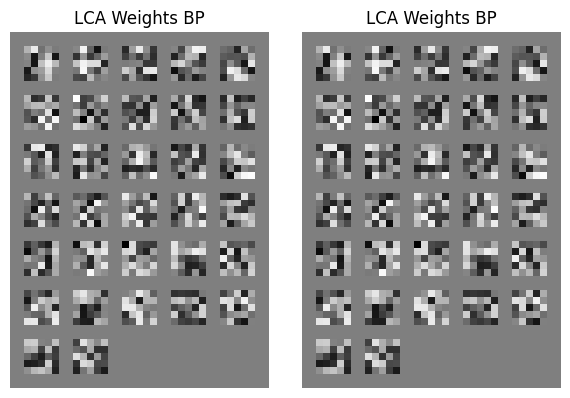

In [170]:
print('Weights the same?', (model_1.synapses[0].weights.detach().numpy() == model_2.synapses[0].weights).all().detach().numpy())

feat_grid = make_feature_grid(model_1.synapses[0].weights)
feat_grid_2 = make_feature_grid(model_2.synapses[0].weights)

fig, axes = plt.subplots(1, 2, figsize=(6, 4))

# Plot the first feature grid in the first subplot
axes[0].imshow(feat_grid.float().cpu().numpy())
axes[0].set_title(f"LCA Weights {model_type_1}")
axes[0].axis('off')  # Hide axis labels

# Plot the second feature grid in the second subplot
axes[1].imshow(feat_grid_2.float().cpu().numpy())
axes[1].set_title(f"LCA Weights {model_type_2}")
axes[1].axis('off')  # Hide axis labels

plt.tight_layout()
plt.show()


### Back Propagation Training

In [110]:
files = list_files(recon_path_bp, extension='.txt')
print(files)
print()
hyperparams_bp = read_hyperparameters(recon_path_bp + '/hyperparameters.txt')

['hyperparameters.txt']



In [8]:
files = list_files(recon_path_bp, extension='.png')
print(files)

['lca_weights.png', 'neural_activity.png']


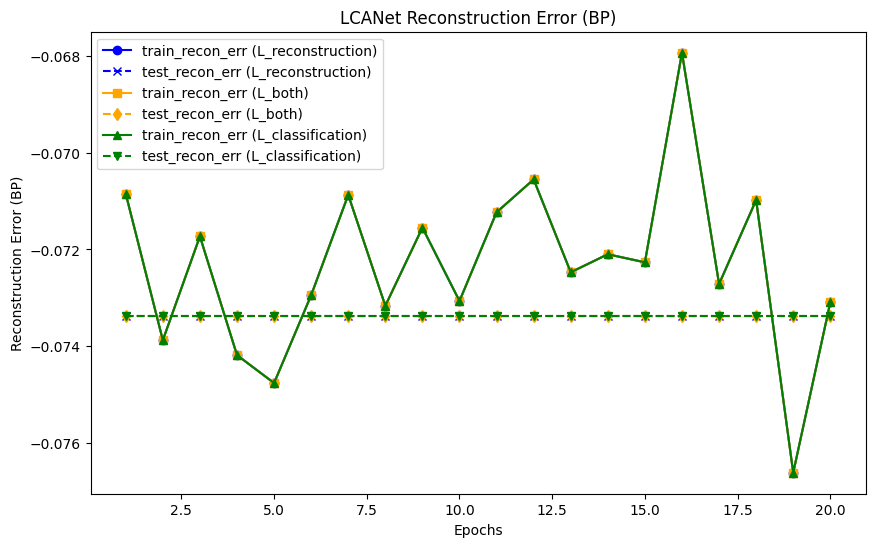

In [12]:
model_checkpoint = class_checkpoint_bp
recon_plots = plot_metrics(model_checkpoint, model_checkpoint, model_checkpoint, 'train_recon_err', 'test_recon_err', 'Reconstruction Error (BP)')

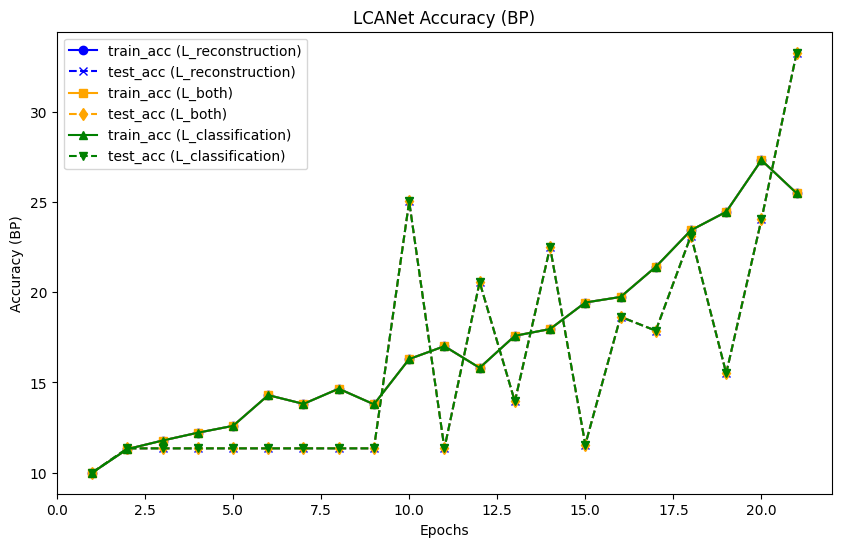

In [13]:
acc_plots = plot_metrics(model_checkpoint, model_checkpoint, model_checkpoint, 'train_acc', 'test_acc', 'Accuracy (BP)')

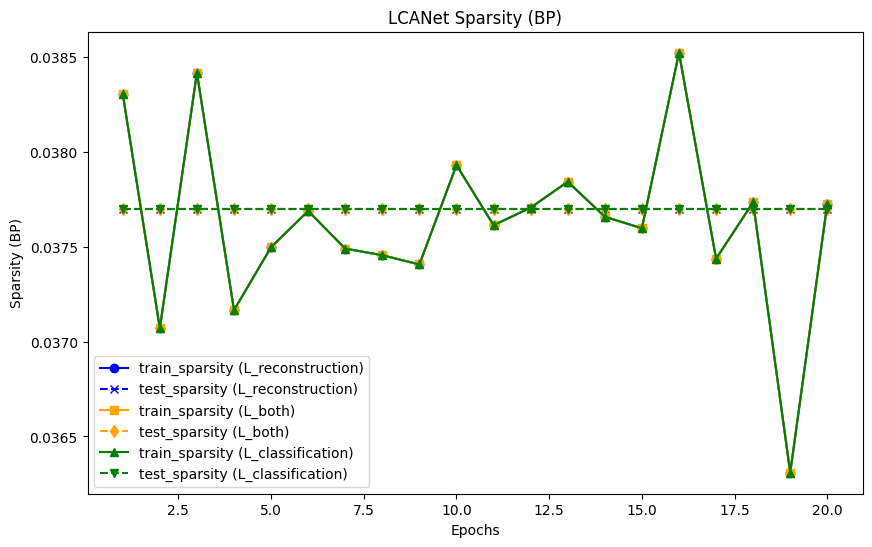

In [14]:
sparsity_plots = plot_metrics(model_checkpoint, model_checkpoint, model_checkpoint, 'train_sparsity', 'test_sparsity', 'Sparsity (BP)')

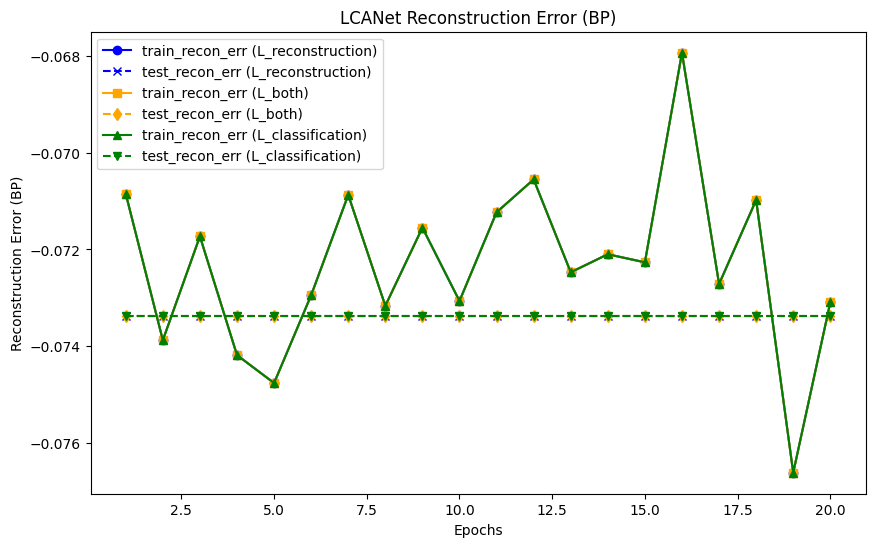

In [11]:
recon_plots = plot_metrics(class_checkpoint_bp, class_checkpoint_bp, class_checkpoint_bp, 'train_recon_err', 'test_recon_err', 'Reconstruction Error (BP)')

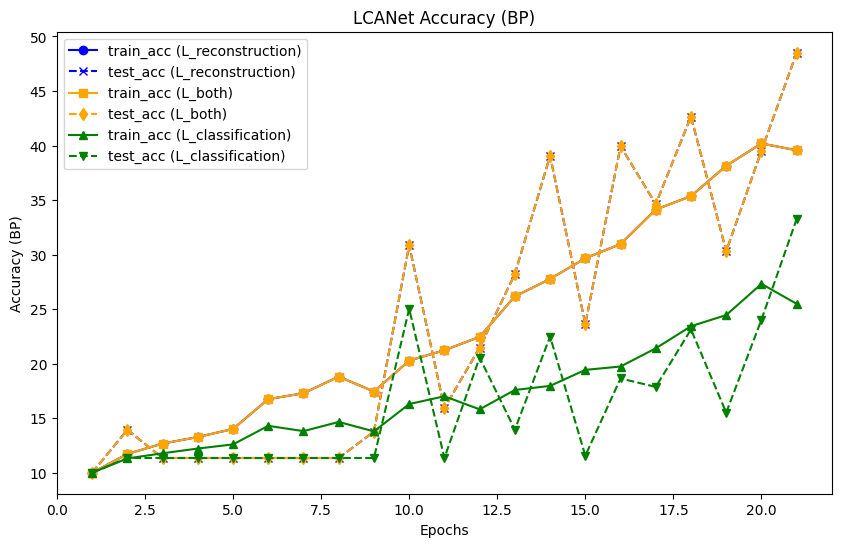

In [33]:
acc_plots = plot_metrics(recon_checkpoint_bp, combo_checkpoint_bp, class_checkpoint_bp, 'train_acc', 'test_acc', 'Accuracy (BP)')

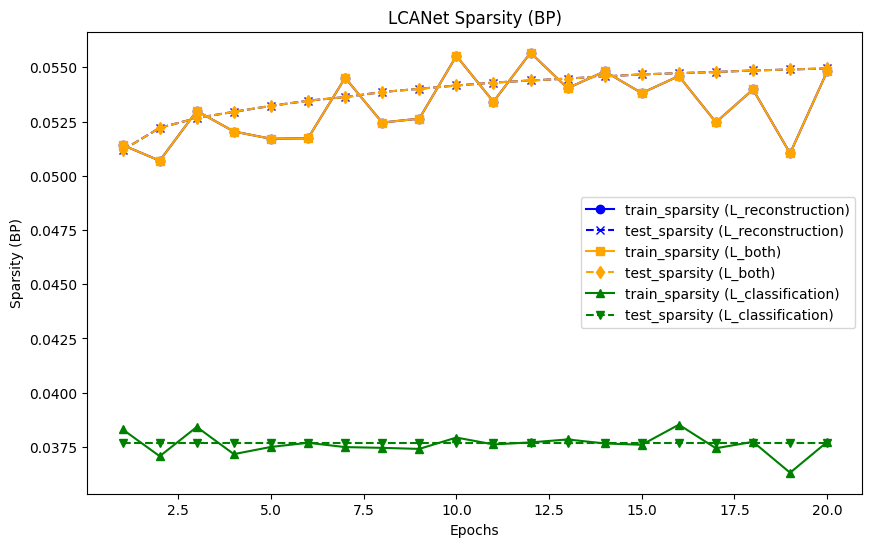

In [34]:
sparsity_plots = plot_metrics(recon_checkpoint_bp, combo_checkpoint_bp, class_checkpoint_bp, 'train_sparsity', 'test_sparsity', 'Sparsity (BP)')

### Equilibrium Propagation Training

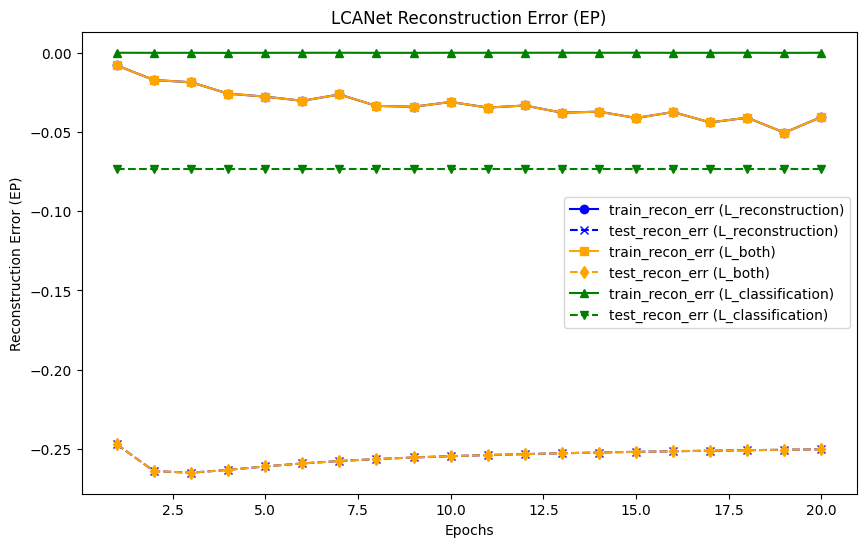

In [35]:
ep_recon_plots = plot_metrics(recon_checkpoint_ep, recon_checkpoint_ep, class_checkpoint_ep, 'train_recon_err', 'test_recon_err', 'Reconstruction Error (EP)')

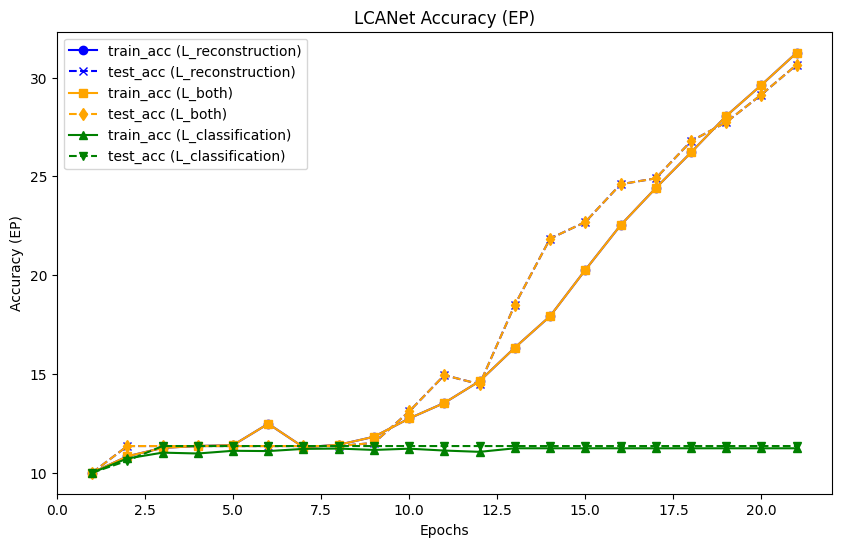

In [36]:
ep_acc_plots = plot_metrics(recon_checkpoint_ep, recon_checkpoint_ep, class_checkpoint_ep, 'train_acc', 'test_acc', 'Accuracy (EP)')

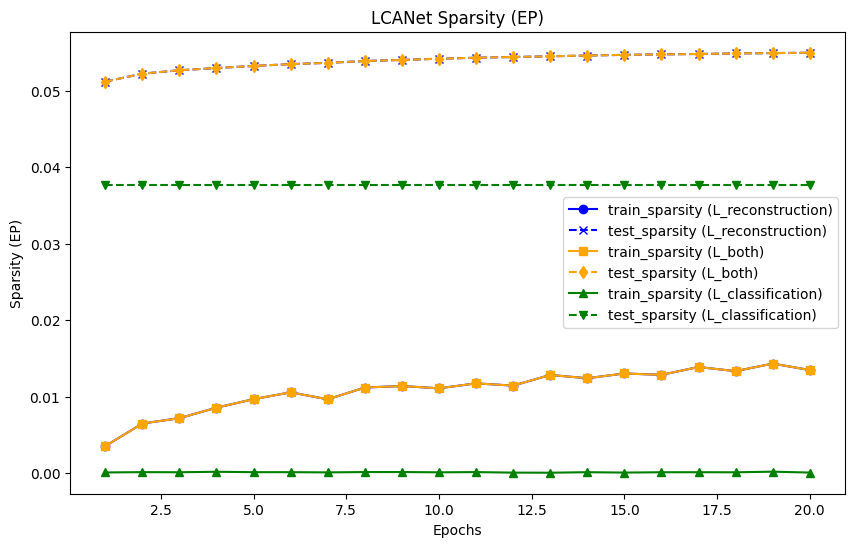

In [37]:
ep_sparsity_plots = plot_metrics(recon_checkpoint_ep, recon_checkpoint_ep, class_checkpoint_ep, 'train_sparsity', 'test_sparsity', 'Sparsity (EP)')